In [114]:
import numpy as np
import seaborn as sns
import torch
import random
import pathlib
import os
import glob
from scipy import io
import cv2
import math
from matplotlib import pyplot as plt
import pandas as pd
from skimage.transform import resize
import tqdm
import torch.nn.functional as F

from PraNet.utils.dataloader import test_dataset
from PraNet.lib.PraNet_Res2Net import PraNet
from skimage.filters import gaussian
from skimage.morphology import label as connected_components

In [64]:
def _prepare_patching(img, pred, gt_, window_size, mask_size, return_src_top_corner=False):
    """Prepare patch information for tile processing.
    
    Args:
        img: original input image
        window_size: input patch size
        mask_size: output patch size
        return_src_top_corner: whether to return coordiante information for top left corner of img
        
    """

    win_size = window_size
    msk_size = step_size = mask_size

    def get_last_steps(length, msk_size, step_size):
        nr_step = math.ceil((length - msk_size) / step_size)
        last_step = (nr_step + 1) * step_size
        return int(last_step), int(nr_step + 1)

    im_h = img.shape[0]
    im_w = img.shape[1]

    last_h, _ = get_last_steps(im_h, msk_size, step_size)
    last_w, _ = get_last_steps(im_w, msk_size, step_size)

    diff = win_size - step_size
    padt = padl = diff // 2
    padb = last_h + win_size - im_h
    padr = last_w + win_size - im_w

    img = np.lib.pad(img, ((padt, padb), (padl, padr), (0, 0)), "reflect")
    pred = np.lib.pad(pred, ((padt, padb), (padl, padr)), "reflect")
    gt_ = np.lib.pad(gt_, ((padt, padb), (padl, padr)), "reflect")

    # generating subpatches index from orginal
    coord_y = np.arange(0, last_h, step_size, dtype=np.int32)
    coord_x = np.arange(0, last_w, step_size, dtype=np.int32)
    row_idx = np.arange(0, coord_y.shape[0], dtype=np.int32)
    col_idx = np.arange(0, coord_x.shape[0], dtype=np.int32)
    coord_y, coord_x = np.meshgrid(coord_y, coord_x)
    row_idx, col_idx = np.meshgrid(row_idx, col_idx)
    coord_y = coord_y.flatten()
    coord_x = coord_x.flatten()
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()
    #
    patch_info = np.stack([coord_y, coord_x, row_idx, col_idx], axis=-1)
    if not return_src_top_corner:
        return img, pred, gt_,patch_info
    else:
        return img, pred, gt_, patch_info, [padt, padl]

In [3]:
def fix_randomness(seed=0):
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [36]:

io.loadmat('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/test_1.mat')['inst_map']
w_pred = np.load('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/pred_hovernet/test_1.npy',allow_pickle=False)

w_pred[0]

(1000, 1000, 3)

In [46]:
img_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/**'
labels_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/**'
glob.glob(img_path),glob.glob(labels_path),glob.glob(img_path)[0].split('Images/')[1].split('.png')



(['/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_12.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_3.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_5.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_14.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_11.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_6.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_2.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_10.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_9.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_4.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_1.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/test_7.png',
  '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Im

In [52]:
img_files.split('Images/')[0]+'Labels/'+img_files.split('Images/')[1].split('.png')[0]

'/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/test_12'

In [97]:
import tqdm
tqdm.tqdm?

In [141]:
window_size = 164
img_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/**'
labels_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/**'
pred_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/pred_hovernet/**'
pbar = tqdm.tqdm(
                desc="Processing Patches",
                leave=True,
                total=int(len(glob.glob(img_path))*(math.ceil(1000/window_size)**2)),
                ncols=80,
                ascii=True,
                position=0,
            )
counter = 0
for indx,img_files in enumerate(glob.glob(img_path)):
    w_img = cv2.imread(img_files)
    w_img = cv2.cvtColor(w_img, cv2.COLOR_BGR2RGB)
    w_label = io.loadmat(img_files.split('Images/')[0]+'Labels/'+img_files.split('Images/')[1].split('.png')[0]+'.mat')['inst_map']
    w_pred = np.load(img_files.split('Images/')[0]+'pred_hovernet/'+img_files.split('Images/')[1].split('.png')[0]+'.npy',allow_pickle=False)[:,:,0]
    
    img,pred,gt, patch_info_list= _prepare_patching(w_img,w_pred,w_label, window_size = window_size, mask_size = 164)
#     print(len(patch_info_list))
    for i in range(len(patch_info_list)):
        
        patch_img = img[
            patch_info_list[i][0] : patch_info_list[i][0] + window_size,
            patch_info_list[i][1] : patch_info_list[i][1] + window_size,
        ]
        patch_pred = pred[
            patch_info_list[i][0] : patch_info_list[i][0] + window_size,
            patch_info_list[i][1] : patch_info_list[i][1] + window_size,
        ]
        patch_gt = gt[
            patch_info_list[i][0] : patch_info_list[i][0] + window_size,
            patch_info_list[i][1] : patch_info_list[i][1] + window_size,
        ]
        
        if patch_gt.sum()==0:
            continue
        else:
            if counter==0:
                patch_img_accum = torch.tensor(patch_img).unsqueeze(dim=0)
                patch_pred_accum = torch.tensor(patch_pred).unsqueeze(dim=0)
                patch_gt_accum = torch.tensor(patch_gt).unsqueeze(dim=0)
                counter +=1

            else:
                patch_img_accum = torch.cat((patch_img_accum,torch.tensor(patch_img).unsqueeze(dim=0)),dim=0)
                patch_pred_accum = torch.cat((patch_pred_accum,torch.tensor(patch_pred).unsqueeze(dim=0)),dim=0)
                patch_gt_accum =torch.cat((patch_gt_accum,torch.tensor(patch_gt).unsqueeze(dim=0)),dim=0)
                counter +=1
                
            
        pbar.update()
pbar.close()

Processing Patches:  95%|#################### | 654/686 [00:21<00:01, 30.38it/s]


In [142]:
# len(patch_img_accum)

654

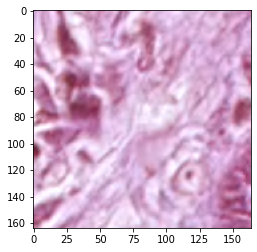

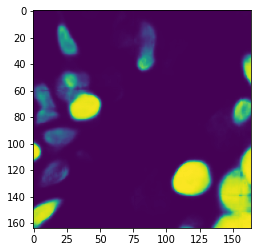

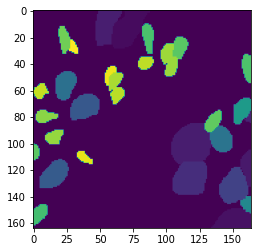

In [143]:
import math
plt.imshow(patch_img_accum[100])
plt.figure()
plt.imshow(patch_pred_accum[100])
plt.figure()
plt.imshow(patch_gt_accum[100])

In [124]:
# patch_img_accum,patch_pred_accum,patch_gt_accum

In [144]:
num_trials = 1000
num_calib = 500
num_lam = 500
alpha = 0.1
lambdas_example_table = np.linspace(-1,0,500)

In [145]:
masks = patch_gt_accum
regions = patch_pred_accum
# num_components = get_data(cache_path)
masks[masks > 1] = 1

In [151]:
def loss_perpolyp_01(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
    missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
    F.relu(missed, inplace=True) 
    # Split the different polyps into different rows.
    missed = missed * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_missed = missed[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
        masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
        k += temp_missed.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/masks_perpolyp.sum(dim=1).sum(dim=1)    
    return results_perpolyp

In [152]:
def get_example_loss_and_size_tables(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
            print(type(est_regions),est_regions.shape,masks.shape)
            loss_table[:,j] = loss_perpolyp_01(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [153]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat(calib_losses[:,::-1], lambdas_example_table[::-1], alpha)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

In [154]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) >= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]


In [162]:
def experiment(masks, regions, alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table):
#     img_names, sigmoids, masks, regions, num_components = get_data(cache_path)
    masks[masks > 1] = 1
    fname = cache_path + f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'

    df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    try:
        print('Dataframe loaded')
        df = pd.read_pickle(fname)
    except:
        example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

        local_df_list = []
        for i in tqdm.tqdm(range(num_trials)):
            lhat, risk, sizes = trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
                
            dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
            df_local = pd.DataFrame(dict_local, index=[i])
            local_df_list = local_df_list + [df_local]
        df = pd.concat(local_df_list, axis=0, ignore_index=True)
        df.to_pickle(fname)

    return df

In [163]:
def plot_histograms(df, alpha, output_dir):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].hist(df['risk'].to_numpy(), alpha=0.7, density=True)

    normalized_size = df['sizes'].to_numpy()
    axs[1].hist(normalized_size, bins=60, alpha=0.7, density=True)

    axs[0].set_xlabel('risk')
    axs[0].locator_params(axis='x', nbins=10)
    axs[0].axvline(x=alpha,c='#999999',linestyle='--',alpha=0.7)
    axs[0].set_ylabel('density')
    axs[1].set_xlabel('set size as a fraction of polyp size')
    axs[1].locator_params(axis='x', nbins=10)
    axs[1].set_yscale('log')
    #axs[1].legend()
    sns.despine(top=True, right=True, ax=axs[0])
    sns.despine(top=True, right=True, ax=axs[1])
    plt.tight_layout()
    plt.savefig( output_dir + (f'{alpha}_polyp_histograms').replace('.','_') + '.pdf'  )
    print(f"The mean and standard deviation of the risk over {len(df)} trials are {df['risk'].mean()} and {df['risk'].std()} respectively.")

Dataframe loaded
computing loss and size table


  0%|                                                                                                                                                   | 0/500 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  0%|▎                                                                                                                                          | 1/500 [00:00<03:45,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  0%|▌                                                                                                                                          | 2/500 [00:00<03:51,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  1%|▊                                                                                                                                          | 3/500 [00:01<03:48,  2.18it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  1%|█                                                                                                                                          | 4/500 [00:01<03:52,  2.14it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  1%|█▍                                                                                                                                         | 5/500 [00:02<04:03,  2.03it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  1%|█▋                                                                                                                                         | 6/500 [00:02<04:06,  2.01it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  1%|█▉                                                                                                                                         | 7/500 [00:03<03:57,  2.08it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  2%|██▏                                                                                                                                        | 8/500 [00:03<03:53,  2.11it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  2%|██▌                                                                                                                                        | 9/500 [00:04<03:58,  2.06it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  2%|██▊                                                                                                                                       | 10/500 [00:04<03:51,  2.12it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  2%|███                                                                                                                                       | 11/500 [00:05<03:45,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  2%|███▎                                                                                                                                      | 12/500 [00:05<03:46,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  3%|███▌                                                                                                                                      | 13/500 [00:06<03:50,  2.11it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  3%|███▊                                                                                                                                      | 14/500 [00:06<03:46,  2.14it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  3%|████▏                                                                                                                                     | 15/500 [00:07<03:47,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  3%|████▍                                                                                                                                     | 16/500 [00:07<03:53,  2.07it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  3%|████▋                                                                                                                                     | 17/500 [00:08<03:54,  2.06it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  4%|████▉                                                                                                                                     | 18/500 [00:08<03:51,  2.08it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  4%|█████▏                                                                                                                                    | 19/500 [00:09<03:52,  2.07it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  4%|█████▌                                                                                                                                    | 20/500 [00:09<03:52,  2.07it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  4%|█████▊                                                                                                                                    | 21/500 [00:09<03:47,  2.10it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  4%|██████                                                                                                                                    | 22/500 [00:10<03:45,  2.12it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  5%|██████▎                                                                                                                                   | 23/500 [00:10<03:44,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  5%|██████▌                                                                                                                                   | 24/500 [00:11<03:39,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  5%|██████▉                                                                                                                                   | 25/500 [00:11<03:36,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  5%|███████▏                                                                                                                                  | 26/500 [00:12<03:33,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  5%|███████▍                                                                                                                                  | 27/500 [00:12<03:33,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  6%|███████▋                                                                                                                                  | 28/500 [00:13<03:35,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  6%|████████                                                                                                                                  | 29/500 [00:13<03:48,  2.06it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  6%|████████▎                                                                                                                                 | 30/500 [00:14<03:44,  2.10it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  6%|████████▌                                                                                                                                 | 31/500 [00:14<03:37,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  6%|████████▊                                                                                                                                 | 32/500 [00:15<03:32,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  7%|█████████                                                                                                                                 | 33/500 [00:15<03:32,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  7%|█████████▍                                                                                                                                | 34/500 [00:15<03:32,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  7%|█████████▋                                                                                                                                | 35/500 [00:16<03:37,  2.14it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  7%|█████████▉                                                                                                                                | 36/500 [00:17<03:50,  2.01it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  7%|██████████▏                                                                                                                               | 37/500 [00:17<03:42,  2.08it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  8%|██████████▍                                                                                                                               | 38/500 [00:17<03:39,  2.11it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  8%|██████████▊                                                                                                                               | 39/500 [00:18<03:32,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  8%|███████████                                                                                                                               | 40/500 [00:18<03:28,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  8%|███████████▎                                                                                                                              | 41/500 [00:19<03:25,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  8%|███████████▌                                                                                                                              | 42/500 [00:19<03:22,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  9%|███████████▊                                                                                                                              | 43/500 [00:20<03:23,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  9%|████████████▏                                                                                                                             | 44/500 [00:20<03:30,  2.16it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  9%|████████████▍                                                                                                                             | 45/500 [00:21<03:27,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  9%|████████████▋                                                                                                                             | 46/500 [00:21<03:24,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


  9%|████████████▉                                                                                                                             | 47/500 [00:21<03:21,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 10%|█████████████▏                                                                                                                            | 48/500 [00:22<03:18,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 10%|█████████████▌                                                                                                                            | 49/500 [00:22<03:17,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 10%|█████████████▊                                                                                                                            | 50/500 [00:23<03:15,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 10%|██████████████                                                                                                                            | 51/500 [00:23<03:14,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 10%|██████████████▎                                                                                                                           | 52/500 [00:24<03:13,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 11%|██████████████▋                                                                                                                           | 53/500 [00:24<03:12,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 11%|██████████████▉                                                                                                                           | 54/500 [00:24<03:12,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 11%|███████████████▏                                                                                                                          | 55/500 [00:25<03:11,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 11%|███████████████▍                                                                                                                          | 56/500 [00:25<03:10,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 11%|███████████████▋                                                                                                                          | 57/500 [00:26<03:10,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 12%|████████████████                                                                                                                          | 58/500 [00:26<03:11,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 12%|████████████████▎                                                                                                                         | 59/500 [00:27<03:11,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 12%|████████████████▌                                                                                                                         | 60/500 [00:27<03:12,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 12%|████████████████▊                                                                                                                         | 61/500 [00:27<03:11,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 12%|█████████████████                                                                                                                         | 62/500 [00:28<03:11,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 13%|█████████████████▍                                                                                                                        | 63/500 [00:28<03:10,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 13%|█████████████████▋                                                                                                                        | 64/500 [00:29<03:09,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 13%|█████████████████▉                                                                                                                        | 65/500 [00:29<03:08,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 13%|██████████████████▏                                                                                                                       | 66/500 [00:30<03:08,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 13%|██████████████████▍                                                                                                                       | 67/500 [00:30<03:07,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 14%|██████████████████▊                                                                                                                       | 68/500 [00:31<03:08,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 14%|███████████████████                                                                                                                       | 69/500 [00:31<03:06,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 14%|███████████████████▎                                                                                                                      | 70/500 [00:31<03:05,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 14%|███████████████████▌                                                                                                                      | 71/500 [00:32<03:04,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 14%|███████████████████▊                                                                                                                      | 72/500 [00:32<03:06,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 15%|████████████████████▏                                                                                                                     | 73/500 [00:33<03:05,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 15%|████████████████████▍                                                                                                                     | 74/500 [00:33<03:04,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 15%|████████████████████▋                                                                                                                     | 75/500 [00:34<03:04,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 15%|████████████████████▉                                                                                                                     | 76/500 [00:34<03:02,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 15%|█████████████████████▎                                                                                                                    | 77/500 [00:34<03:01,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 16%|█████████████████████▌                                                                                                                    | 78/500 [00:35<03:00,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 16%|█████████████████████▊                                                                                                                    | 79/500 [00:35<03:00,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 16%|██████████████████████                                                                                                                    | 80/500 [00:36<03:00,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 16%|██████████████████████▎                                                                                                                   | 81/500 [00:36<02:59,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 16%|██████████████████████▋                                                                                                                   | 82/500 [00:37<02:58,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 17%|██████████████████████▉                                                                                                                   | 83/500 [00:37<02:59,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 17%|███████████████████████▏                                                                                                                  | 84/500 [00:37<02:59,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 17%|███████████████████████▍                                                                                                                  | 85/500 [00:38<02:58,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 17%|███████████████████████▋                                                                                                                  | 86/500 [00:38<02:58,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 17%|████████████████████████                                                                                                                  | 87/500 [00:39<02:58,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 18%|████████████████████████▎                                                                                                                 | 88/500 [00:39<02:58,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 18%|████████████████████████▌                                                                                                                 | 89/500 [00:40<02:57,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 18%|████████████████████████▊                                                                                                                 | 90/500 [00:40<02:57,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 18%|█████████████████████████                                                                                                                 | 91/500 [00:40<02:56,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 18%|█████████████████████████▍                                                                                                                | 92/500 [00:41<02:55,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 19%|█████████████████████████▋                                                                                                                | 93/500 [00:41<02:55,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 19%|█████████████████████████▉                                                                                                                | 94/500 [00:42<02:55,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 19%|██████████████████████████▏                                                                                                               | 95/500 [00:42<02:55,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 19%|██████████████████████████▍                                                                                                               | 96/500 [00:43<02:56,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 19%|██████████████████████████▊                                                                                                               | 97/500 [00:43<02:56,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 20%|███████████████████████████                                                                                                               | 98/500 [00:43<02:55,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 20%|███████████████████████████▎                                                                                                              | 99/500 [00:44<02:54,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 20%|███████████████████████████▍                                                                                                             | 100/500 [00:44<02:53,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 20%|███████████████████████████▋                                                                                                             | 101/500 [00:45<02:52,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 20%|███████████████████████████▉                                                                                                             | 102/500 [00:45<02:53,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 21%|████████████████████████████▏                                                                                                            | 103/500 [00:46<02:52,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 21%|████████████████████████████▍                                                                                                            | 104/500 [00:46<03:04,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 21%|████████████████████████████▊                                                                                                            | 105/500 [00:47<02:59,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 21%|█████████████████████████████                                                                                                            | 106/500 [00:47<02:56,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 21%|█████████████████████████████▎                                                                                                           | 107/500 [00:47<02:53,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 22%|█████████████████████████████▌                                                                                                           | 108/500 [00:48<02:51,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 22%|█████████████████████████████▊                                                                                                           | 109/500 [00:48<02:54,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 22%|██████████████████████████████▏                                                                                                          | 110/500 [00:49<02:51,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 22%|██████████████████████████████▍                                                                                                          | 111/500 [00:49<02:49,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 22%|██████████████████████████████▋                                                                                                          | 112/500 [00:50<02:49,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 23%|██████████████████████████████▉                                                                                                          | 113/500 [00:50<02:47,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 23%|███████████████████████████████▏                                                                                                         | 114/500 [00:51<02:47,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 23%|███████████████████████████████▌                                                                                                         | 115/500 [00:51<02:47,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 23%|███████████████████████████████▊                                                                                                         | 116/500 [00:51<02:46,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 23%|████████████████████████████████                                                                                                         | 117/500 [00:52<02:46,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 24%|████████████████████████████████▎                                                                                                        | 118/500 [00:52<02:45,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 24%|████████████████████████████████▌                                                                                                        | 119/500 [00:53<02:45,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 24%|████████████████████████████████▉                                                                                                        | 120/500 [00:53<02:44,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 24%|█████████████████████████████████▏                                                                                                       | 121/500 [00:54<02:43,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 24%|█████████████████████████████████▍                                                                                                       | 122/500 [00:54<02:42,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 25%|█████████████████████████████████▋                                                                                                       | 123/500 [00:54<02:42,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 25%|█████████████████████████████████▉                                                                                                       | 124/500 [00:55<02:41,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 25%|██████████████████████████████████▎                                                                                                      | 125/500 [00:55<02:41,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 25%|██████████████████████████████████▌                                                                                                      | 126/500 [00:56<02:40,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 25%|██████████████████████████████████▊                                                                                                      | 127/500 [00:56<02:40,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 26%|███████████████████████████████████                                                                                                      | 128/500 [00:57<02:40,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 26%|███████████████████████████████████▎                                                                                                     | 129/500 [00:57<02:40,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 26%|███████████████████████████████████▌                                                                                                     | 130/500 [00:57<02:40,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 26%|███████████████████████████████████▉                                                                                                     | 131/500 [00:58<02:39,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 26%|████████████████████████████████████▏                                                                                                    | 132/500 [00:58<02:39,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 27%|████████████████████████████████████▍                                                                                                    | 133/500 [00:59<02:38,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 27%|████████████████████████████████████▋                                                                                                    | 134/500 [00:59<02:37,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 27%|████████████████████████████████████▉                                                                                                    | 135/500 [01:00<02:41,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 27%|█████████████████████████████████████▎                                                                                                   | 136/500 [01:00<02:41,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 27%|█████████████████████████████████████▌                                                                                                   | 137/500 [01:01<02:43,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 28%|█████████████████████████████████████▊                                                                                                   | 138/500 [01:01<02:52,  2.09it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 28%|██████████████████████████████████████                                                                                                   | 139/500 [01:02<02:59,  2.01it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 28%|██████████████████████████████████████▎                                                                                                  | 140/500 [01:02<02:56,  2.03it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 28%|██████████████████████████████████████▋                                                                                                  | 141/500 [01:03<02:55,  2.04it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 28%|██████████████████████████████████████▉                                                                                                  | 142/500 [01:03<02:55,  2.04it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 29%|███████████████████████████████████████▏                                                                                                 | 143/500 [01:04<02:51,  2.09it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 29%|███████████████████████████████████████▍                                                                                                 | 144/500 [01:04<02:50,  2.08it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 29%|███████████████████████████████████████▋                                                                                                 | 145/500 [01:04<02:46,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 29%|████████████████████████████████████████                                                                                                 | 146/500 [01:05<02:40,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 29%|████████████████████████████████████████▎                                                                                                | 147/500 [01:05<02:40,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 30%|████████████████████████████████████████▌                                                                                                | 148/500 [01:06<02:35,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 30%|████████████████████████████████████████▊                                                                                                | 149/500 [01:06<02:32,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 30%|█████████████████████████████████████████                                                                                                | 150/500 [01:07<02:30,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 30%|█████████████████████████████████████████▎                                                                                               | 151/500 [01:07<02:30,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 30%|█████████████████████████████████████████▋                                                                                               | 152/500 [01:07<02:31,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 31%|█████████████████████████████████████████▉                                                                                               | 153/500 [01:08<02:30,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 31%|██████████████████████████████████████████▏                                                                                              | 154/500 [01:08<02:33,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 31%|██████████████████████████████████████████▍                                                                                              | 155/500 [01:09<02:32,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 31%|██████████████████████████████████████████▋                                                                                              | 156/500 [01:09<02:28,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 31%|███████████████████████████████████████████                                                                                              | 157/500 [01:10<02:35,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 32%|███████████████████████████████████████████▎                                                                                             | 158/500 [01:10<02:31,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 32%|███████████████████████████████████████████▌                                                                                             | 159/500 [01:11<02:31,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 32%|███████████████████████████████████████████▊                                                                                             | 160/500 [01:11<02:28,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 32%|████████████████████████████████████████████                                                                                             | 161/500 [01:11<02:30,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 32%|████████████████████████████████████████████▍                                                                                            | 162/500 [01:12<02:28,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 33%|████████████████████████████████████████████▋                                                                                            | 163/500 [01:12<02:25,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 33%|████████████████████████████████████████████▉                                                                                            | 164/500 [01:13<02:29,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 33%|█████████████████████████████████████████████▏                                                                                           | 165/500 [01:13<02:26,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 33%|█████████████████████████████████████████████▍                                                                                           | 166/500 [01:14<02:24,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 33%|█████████████████████████████████████████████▊                                                                                           | 167/500 [01:14<02:21,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 34%|██████████████████████████████████████████████                                                                                           | 168/500 [01:14<02:23,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 34%|██████████████████████████████████████████████▎                                                                                          | 169/500 [01:15<02:23,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 34%|██████████████████████████████████████████████▌                                                                                          | 170/500 [01:15<02:22,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 34%|██████████████████████████████████████████████▊                                                                                          | 171/500 [01:16<02:26,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 34%|███████████████████████████████████████████████▏                                                                                         | 172/500 [01:16<02:22,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 35%|███████████████████████████████████████████████▍                                                                                         | 173/500 [01:17<02:21,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 35%|███████████████████████████████████████████████▋                                                                                         | 174/500 [01:17<02:19,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 35%|███████████████████████████████████████████████▉                                                                                         | 175/500 [01:17<02:17,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 35%|████████████████████████████████████████████████▏                                                                                        | 176/500 [01:18<02:16,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 35%|████████████████████████████████████████████████▍                                                                                        | 177/500 [01:18<02:14,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 36%|████████████████████████████████████████████████▊                                                                                        | 178/500 [01:19<02:18,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 36%|█████████████████████████████████████████████████                                                                                        | 179/500 [01:19<02:17,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 36%|█████████████████████████████████████████████████▎                                                                                       | 180/500 [01:20<02:17,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 36%|█████████████████████████████████████████████████▌                                                                                       | 181/500 [01:20<02:15,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 36%|█████████████████████████████████████████████████▊                                                                                       | 182/500 [01:20<02:13,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 37%|██████████████████████████████████████████████████▏                                                                                      | 183/500 [01:21<02:12,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 37%|██████████████████████████████████████████████████▍                                                                                      | 184/500 [01:21<02:11,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 37%|██████████████████████████████████████████████████▋                                                                                      | 185/500 [01:22<02:14,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 37%|██████████████████████████████████████████████████▉                                                                                      | 186/500 [01:22<02:14,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 37%|███████████████████████████████████████████████████▏                                                                                     | 187/500 [01:23<02:13,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 38%|███████████████████████████████████████████████████▌                                                                                     | 188/500 [01:23<02:11,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 38%|███████████████████████████████████████████████████▊                                                                                     | 189/500 [01:23<02:10,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 38%|████████████████████████████████████████████████████                                                                                     | 190/500 [01:24<02:10,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 38%|████████████████████████████████████████████████████▎                                                                                    | 191/500 [01:24<02:08,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 38%|████████████████████████████████████████████████████▌                                                                                    | 192/500 [01:25<02:08,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 39%|████████████████████████████████████████████████████▉                                                                                    | 193/500 [01:25<02:07,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 39%|█████████████████████████████████████████████████████▏                                                                                   | 194/500 [01:25<02:06,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 39%|█████████████████████████████████████████████████████▍                                                                                   | 195/500 [01:26<02:06,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 39%|█████████████████████████████████████████████████████▋                                                                                   | 196/500 [01:26<02:05,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 39%|█████████████████████████████████████████████████████▉                                                                                   | 197/500 [01:27<02:05,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 40%|██████████████████████████████████████████████████████▎                                                                                  | 198/500 [01:27<02:05,  2.42it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 40%|██████████████████████████████████████████████████████▌                                                                                  | 199/500 [01:28<02:04,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 40%|██████████████████████████████████████████████████████▊                                                                                  | 200/500 [01:28<02:04,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 40%|███████████████████████████████████████████████████████                                                                                  | 201/500 [01:28<02:07,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 40%|███████████████████████████████████████████████████████▎                                                                                 | 202/500 [01:29<02:10,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 41%|███████████████████████████████████████████████████████▌                                                                                 | 203/500 [01:29<02:14,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 41%|███████████████████████████████████████████████████████▉                                                                                 | 204/500 [01:30<02:11,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 41%|████████████████████████████████████████████████████████▏                                                                                | 205/500 [01:30<02:08,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 41%|████████████████████████████████████████████████████████▍                                                                                | 206/500 [01:31<02:08,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 41%|████████████████████████████████████████████████████████▋                                                                                | 207/500 [01:31<02:07,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 42%|████████████████████████████████████████████████████████▉                                                                                | 208/500 [01:31<02:05,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 42%|█████████████████████████████████████████████████████████▎                                                                               | 209/500 [01:32<02:07,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 42%|█████████████████████████████████████████████████████████▌                                                                               | 210/500 [01:32<02:09,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 42%|█████████████████████████████████████████████████████████▊                                                                               | 211/500 [01:33<02:08,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 42%|██████████████████████████████████████████████████████████                                                                               | 212/500 [01:33<02:05,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 43%|██████████████████████████████████████████████████████████▎                                                                              | 213/500 [01:34<02:06,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 43%|██████████████████████████████████████████████████████████▋                                                                              | 214/500 [01:34<02:04,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 43%|██████████████████████████████████████████████████████████▉                                                                              | 215/500 [01:35<02:02,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 43%|███████████████████████████████████████████████████████████▏                                                                             | 216/500 [01:35<02:00,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 43%|███████████████████████████████████████████████████████████▍                                                                             | 217/500 [01:35<01:58,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 44%|███████████████████████████████████████████████████████████▋                                                                             | 218/500 [01:36<01:58,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 44%|████████████████████████████████████████████████████████████                                                                             | 219/500 [01:36<01:57,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 44%|████████████████████████████████████████████████████████████▎                                                                            | 220/500 [01:37<01:57,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 44%|████████████████████████████████████████████████████████████▌                                                                            | 221/500 [01:37<02:00,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 44%|████████████████████████████████████████████████████████████▊                                                                            | 222/500 [01:38<01:59,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 45%|█████████████████████████████████████████████████████████████                                                                            | 223/500 [01:38<02:02,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 45%|█████████████████████████████████████████████████████████████▍                                                                           | 224/500 [01:38<02:01,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 45%|█████████████████████████████████████████████████████████████▋                                                                           | 225/500 [01:39<01:59,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 45%|█████████████████████████████████████████████████████████████▉                                                                           | 226/500 [01:39<02:01,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 45%|██████████████████████████████████████████████████████████████▏                                                                          | 227/500 [01:40<01:58,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 46%|██████████████████████████████████████████████████████████████▍                                                                          | 228/500 [01:40<01:56,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 46%|██████████████████████████████████████████████████████████████▋                                                                          | 229/500 [01:41<01:54,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 46%|███████████████████████████████████████████████████████████████                                                                          | 230/500 [01:41<01:53,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 46%|███████████████████████████████████████████████████████████████▎                                                                         | 231/500 [01:41<01:52,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 46%|███████████████████████████████████████████████████████████████▌                                                                         | 232/500 [01:42<01:51,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 47%|███████████████████████████████████████████████████████████████▊                                                                         | 233/500 [01:42<01:52,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 47%|████████████████████████████████████████████████████████████████                                                                         | 234/500 [01:43<01:51,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 47%|████████████████████████████████████████████████████████████████▍                                                                        | 235/500 [01:43<01:51,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 47%|████████████████████████████████████████████████████████████████▋                                                                        | 236/500 [01:43<01:50,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 47%|████████████████████████████████████████████████████████████████▉                                                                        | 237/500 [01:44<01:49,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 48%|█████████████████████████████████████████████████████████████████▏                                                                       | 238/500 [01:44<01:49,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 48%|█████████████████████████████████████████████████████████████████▍                                                                       | 239/500 [01:45<01:48,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 240/500 [01:45<01:48,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 48%|██████████████████████████████████████████████████████████████████                                                                       | 241/500 [01:46<01:47,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 48%|██████████████████████████████████████████████████████████████████▎                                                                      | 242/500 [01:46<01:46,  2.41it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 49%|██████████████████████████████████████████████████████████████████▌                                                                      | 243/500 [01:46<01:46,  2.42it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 244/500 [01:47<01:45,  2.42it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 49%|███████████████████████████████████████████████████████████████████▏                                                                     | 245/500 [01:47<01:45,  2.42it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 49%|███████████████████████████████████████████████████████████████████▍                                                                     | 246/500 [01:48<01:46,  2.38it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 49%|███████████████████████████████████████████████████████████████████▋                                                                     | 247/500 [01:48<01:47,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 50%|███████████████████████████████████████████████████████████████████▉                                                                     | 248/500 [01:49<01:47,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 50%|████████████████████████████████████████████████████████████████████▏                                                                    | 249/500 [01:49<01:46,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 250/500 [01:49<01:45,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 251/500 [01:50<01:48,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 252/500 [01:50<01:46,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 51%|█████████████████████████████████████████████████████████████████████▎                                                                   | 253/500 [01:51<01:45,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 51%|█████████████████████████████████████████████████████████████████████▌                                                                   | 254/500 [01:51<01:43,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 255/500 [01:51<01:42,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 51%|██████████████████████████████████████████████████████████████████████▏                                                                  | 256/500 [01:52<01:42,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 51%|██████████████████████████████████████████████████████████████████████▍                                                                  | 257/500 [01:52<01:42,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 258/500 [01:53<01:41,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 259/500 [01:53<01:42,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 260/500 [01:54<01:43,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 52%|███████████████████████████████████████████████████████████████████████▌                                                                 | 261/500 [01:54<01:41,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 52%|███████████████████████████████████████████████████████████████████████▊                                                                 | 262/500 [01:54<01:40,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 53%|████████████████████████████████████████████████████████████████████████                                                                 | 263/500 [01:55<01:39,  2.39it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 264/500 [01:55<01:38,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 53%|████████████████████████████████████████████████████████████████████████▌                                                                | 265/500 [01:56<01:37,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 53%|████████████████████████████████████████████████████████████████████████▉                                                                | 266/500 [01:56<01:37,  2.40it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 267/500 [01:57<01:40,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 54%|█████████████████████████████████████████████████████████████████████████▍                                                               | 268/500 [01:57<01:42,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 54%|█████████████████████████████████████████████████████████████████████████▋                                                               | 269/500 [01:57<01:42,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 270/500 [01:58<01:40,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 271/500 [01:58<01:38,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 54%|██████████████████████████████████████████████████████████████████████████▌                                                              | 272/500 [01:59<01:37,  2.35it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 55%|██████████████████████████████████████████████████████████████████████████▊                                                              | 273/500 [01:59<01:36,  2.36it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 55%|███████████████████████████████████████████████████████████████████████████                                                              | 274/500 [02:00<01:37,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 275/500 [02:00<01:38,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 55%|███████████████████████████████████████████████████████████████████████████▌                                                             | 276/500 [02:01<01:40,  2.23it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 55%|███████████████████████████████████████████████████████████████████████████▉                                                             | 277/500 [02:01<01:43,  2.16it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 278/500 [02:01<01:41,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 279/500 [02:02<01:40,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 280/500 [02:02<01:39,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 56%|████████████████████████████████████████████████████████████████████████████▉                                                            | 281/500 [02:03<01:38,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 282/500 [02:03<01:38,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 283/500 [02:04<01:35,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 284/500 [02:04<01:33,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 57%|██████████████████████████████████████████████████████████████████████████████                                                           | 285/500 [02:05<01:32,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 286/500 [02:05<01:34,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 287/500 [02:05<01:32,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 288/500 [02:06<01:30,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 289/500 [02:06<01:32,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 290/500 [02:07<01:30,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 291/500 [02:07<01:29,  2.34it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 58%|████████████████████████████████████████████████████████████████████████████████                                                         | 292/500 [02:08<01:27,  2.37it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 59%|████████████████████████████████████████████████████████████████████████████████▎                                                        | 293/500 [02:08<01:29,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 59%|████████████████████████████████████████████████████████████████████████████████▌                                                        | 294/500 [02:08<01:30,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 295/500 [02:09<01:28,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 296/500 [02:09<01:27,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 297/500 [02:10<01:29,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 298/500 [02:10<01:29,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                       | 299/500 [02:11<01:30,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 300/500 [02:11<01:29,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 60%|██████████████████████████████████████████████████████████████████████████████████▍                                                      | 301/500 [02:12<01:31,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 302/500 [02:12<01:31,  2.16it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 61%|███████████████████████████████████████████████████████████████████████████████████                                                      | 303/500 [02:13<01:31,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 304/500 [02:13<01:33,  2.11it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 305/500 [02:14<01:33,  2.09it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 61%|███████████████████████████████████████████████████████████████████████████████████▊                                                     | 306/500 [02:14<01:30,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 61%|████████████████████████████████████████████████████████████████████████████████████                                                     | 307/500 [02:14<01:30,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 308/500 [02:15<01:33,  2.05it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 309/500 [02:15<01:30,  2.12it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 310/500 [02:16<01:27,  2.16it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 311/500 [02:16<01:31,  2.06it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                   | 312/500 [02:17<01:28,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 313/500 [02:17<01:25,  2.18it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 314/500 [02:18<01:23,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 315/500 [02:18<01:22,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                  | 316/500 [02:19<01:21,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 63%|██████████████████████████████████████████████████████████████████████████████████████▊                                                  | 317/500 [02:19<01:20,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 318/500 [02:19<01:21,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                 | 319/500 [02:20<01:21,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 320/500 [02:20<01:25,  2.10it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                 | 321/500 [02:21<01:24,  2.13it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 322/500 [02:21<01:22,  2.15it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 65%|████████████████████████████████████████████████████████████████████████████████████████▌                                                | 323/500 [02:22<01:20,  2.20it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                                | 324/500 [02:22<01:18,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 325/500 [02:23<01:23,  2.11it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 326/500 [02:23<01:20,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 327/500 [02:24<01:18,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                               | 328/500 [02:24<01:17,  2.23it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                              | 329/500 [02:24<01:15,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 330/500 [02:25<01:14,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 66%|██████████████████████████████████████████████████████████████████████████████████████████▋                                              | 331/500 [02:25<01:13,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                              | 332/500 [02:26<01:13,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 333/500 [02:26<01:13,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 334/500 [02:27<01:12,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 335/500 [02:27<01:12,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                             | 336/500 [02:28<01:11,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 337/500 [02:28<01:10,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 338/500 [02:28<01:10,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 339/500 [02:29<01:09,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 340/500 [02:29<01:09,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 341/500 [02:30<01:09,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 342/500 [02:30<01:09,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 343/500 [02:31<01:08,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 344/500 [02:31<01:07,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 345/500 [02:31<01:07,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 346/500 [02:32<01:06,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 347/500 [02:32<01:06,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 348/500 [02:33<01:05,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 349/500 [02:33<01:05,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 350/500 [02:34<01:05,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 351/500 [02:34<01:04,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 352/500 [02:34<01:03,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 353/500 [02:35<01:03,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 354/500 [02:35<01:02,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 355/500 [02:36<01:02,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 356/500 [02:36<01:02,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 357/500 [02:37<01:02,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                       | 358/500 [02:37<01:02,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 359/500 [02:38<01:02,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 360/500 [02:38<01:01,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 361/500 [02:38<01:01,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 362/500 [02:39<01:06,  2.09it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 363/500 [02:39<01:04,  2.12it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 364/500 [02:40<01:02,  2.18it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 365/500 [02:40<01:01,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 366/500 [02:41<00:59,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 367/500 [02:41<00:58,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 368/500 [02:42<00:57,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 369/500 [02:42<00:57,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 370/500 [02:42<00:57,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 371/500 [02:43<00:56,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 372/500 [02:43<00:55,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 373/500 [02:44<00:55,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 374/500 [02:44<00:54,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 375/500 [02:45<00:54,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 376/500 [02:45<00:53,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 377/500 [02:45<00:53,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 378/500 [02:46<00:55,  2.18it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 379/500 [02:47<00:58,  2.05it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 380/500 [02:47<00:56,  2.12it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 381/500 [02:47<00:54,  2.17it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 382/500 [02:48<00:53,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 383/500 [02:48<00:52,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 384/500 [02:49<00:52,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 385/500 [02:49<00:51,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 386/500 [02:50<00:51,  2.23it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 387/500 [02:50<00:50,  2.23it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 388/500 [02:51<00:49,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 389/500 [02:51<00:51,  2.14it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 390/500 [02:51<00:50,  2.19it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 391/500 [02:52<00:49,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 392/500 [02:52<00:48,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 393/500 [02:53<00:47,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 394/500 [02:53<00:46,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 395/500 [02:54<00:46,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 396/500 [02:54<00:45,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 397/500 [02:55<00:45,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 398/500 [02:55<00:44,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 399/500 [02:55<00:44,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 400/500 [02:56<00:43,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 401/500 [02:56<00:43,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 402/500 [02:57<00:44,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 403/500 [02:57<00:43,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 404/500 [02:58<00:42,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 405/500 [02:58<00:42,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 406/500 [02:59<00:41,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 407/500 [02:59<00:40,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 408/500 [02:59<00:40,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 409/500 [03:00<00:39,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 410/500 [03:00<00:39,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 411/500 [03:01<00:38,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 412/500 [03:01<00:38,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 413/500 [03:02<00:37,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 414/500 [03:02<00:37,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 415/500 [03:02<00:37,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 416/500 [03:03<00:36,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 417/500 [03:03<00:36,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 418/500 [03:04<00:36,  2.26it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 419/500 [03:04<00:35,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 420/500 [03:05<00:35,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 421/500 [03:05<00:34,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 422/500 [03:06<00:33,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 423/500 [03:06<00:33,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 424/500 [03:06<00:33,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 425/500 [03:07<00:32,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 426/500 [03:07<00:32,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 427/500 [03:08<00:31,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 428/500 [03:08<00:31,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 429/500 [03:09<00:31,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 430/500 [03:09<00:30,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 431/500 [03:10<00:31,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 432/500 [03:10<00:31,  2.18it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 433/500 [03:10<00:30,  2.21it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 434/500 [03:11<00:29,  2.24it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 435/500 [03:11<00:29,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 436/500 [03:12<00:29,  2.16it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 437/500 [03:12<00:28,  2.22it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 438/500 [03:13<00:27,  2.25it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 439/500 [03:13<00:26,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 440/500 [03:14<00:26,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 441/500 [03:14<00:25,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 442/500 [03:14<00:25,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 443/500 [03:15<00:24,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 444/500 [03:15<00:24,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 445/500 [03:16<00:23,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 446/500 [03:16<00:23,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 447/500 [03:17<00:23,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 448/500 [03:17<00:22,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 449/500 [03:17<00:22,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 450/500 [03:18<00:21,  2.27it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 451/500 [03:18<00:21,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 452/500 [03:19<00:21,  2.28it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 453/500 [03:19<00:20,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 454/500 [03:20<00:19,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 455/500 [03:20<00:19,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 456/500 [03:20<00:19,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 457/500 [03:21<00:18,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 458/500 [03:21<00:18,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 459/500 [03:22<00:17,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 460/500 [03:22<00:17,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 461/500 [03:23<00:16,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 462/500 [03:23<00:16,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 463/500 [03:24<00:16,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 464/500 [03:24<00:15,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 465/500 [03:24<00:15,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 466/500 [03:25<00:14,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 467/500 [03:25<00:14,  2.33it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 468/500 [03:26<00:13,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 469/500 [03:26<00:13,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 470/500 [03:27<00:12,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 471/500 [03:27<00:12,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 472/500 [03:27<00:12,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 473/500 [03:28<00:11,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 474/500 [03:28<00:11,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 475/500 [03:29<00:10,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 476/500 [03:29<00:10,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 477/500 [03:30<00:09,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 478/500 [03:30<00:09,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 479/500 [03:30<00:09,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 480/500 [03:31<00:08,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 481/500 [03:31<00:08,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 482/500 [03:32<00:07,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 483/500 [03:32<00:07,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 484/500 [03:33<00:06,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 485/500 [03:33<00:06,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 486/500 [03:33<00:06,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 487/500 [03:34<00:05,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 488/500 [03:34<00:05,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 489/500 [03:35<00:04,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 490/500 [03:35<00:04,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 491/500 [03:36<00:03,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 492/500 [03:36<00:03,  2.32it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 493/500 [03:36<00:03,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 494/500 [03:37<00:02,  2.31it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 495/500 [03:37<00:02,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/500 [03:38<00:01,  2.29it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/500 [03:38<00:01,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [03:39<00:00,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [03:39<00:00,  2.30it/s]

<class 'torch.Tensor'> torch.Size([654, 164, 164]) torch.Size([654, 164, 164])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 609.64it/s]


The mean and standard deviation of the risk over 1000 trials are 0.0892392796390355 and 0.016268083403963265 respectively.


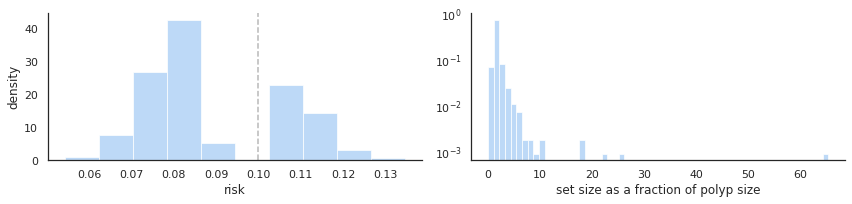

In [166]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = 1000
        num_calib = 500
        num_lam = 500
        alpha = 0.1
        lambdas_example_table = np.linspace(-1,0,500)

        df = experiment(patch_gt_accum, patch_pred_accum, alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table)
        plot_histograms(df, alpha, output_dir)


In [183]:
df['$\hat{\lambda}$'].mean()

-0.004667334669338793

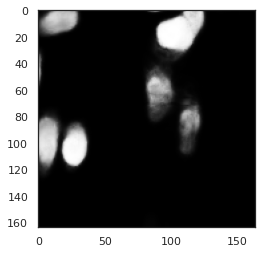

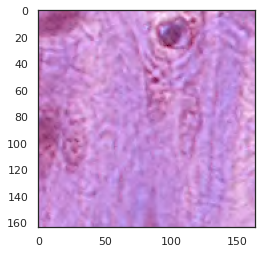

In [214]:
in_dex = 200
plt.imshow(patch_pred_accum[in_dex],cmap='gray')
plt.figure()
plt.imshow(patch_img_accum[in_dex])

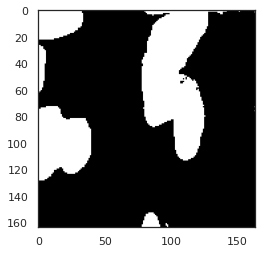

In [210]:
plt.imshow(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()),cmap='gray')

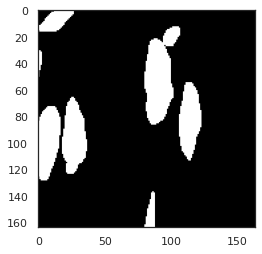

In [211]:
plt.imshow(patch_gt_accum[in_dex],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


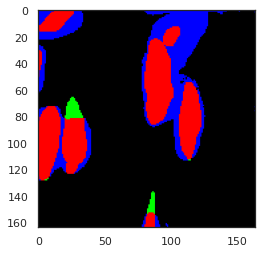

In [212]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)
plt.imshow()

In [243]:
metrics = lambda pred,gt_: ((pred & gt_).sum(),((pred & gt_) ^ (gt_)).sum(),\
                               ((pred & gt_) ^ (pred)).sum(), (~pred & ~gt_).sum())

In [248]:
pred = np.array(patch_pred_accum>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(17.654802539504317, 7.208027533910412)

In [249]:
pred = np.array(patch_pred_accum>0.5)
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(1.8511939227363823, 41.112942806298804)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


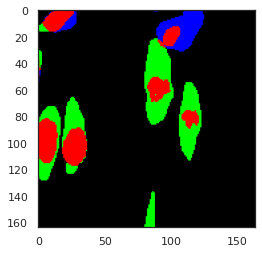

In [213]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>0.5)
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)